### Common Functions

In [1]:
from joblib import dump, load
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy import stats
from tqdm import tqdm
import os

def get_X(metadata, img_loc, adj_loc, pca_loc, add_intercept = True):
  loaded_pca = load(pca_loc)
  img_all = []
  adj_all = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
    for i, record in metadata.iterrows():
      patient, replicate = record[['patient','replicate']]
      img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
      img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                   index = img_features.index,
                                   columns = [f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                   ) # no fitting
      adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col = [0,1,2])
      img_all.append(img_embedding)
      adj_all.append(adj_embedding)
      pbar.update(1)
  features = pd.concat([pd.concat(img_all), pd.concat(adj_all)],axis = 1)
  if add_intercept:
    features.insert(0, 'bias', 1)
  return features

def get_y(metadata, top_genes_loc):
  top_genes = pd.read_csv(top_genes_loc, header = None)[0].tolist()
  # Create target dataset
  y = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading y-labels') as pbar:
    for i, record in metadata.iterrows():
      type_i, patient, replicate = record['type'], record['patient'], record['replicate']
      df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
      # Read the .tsv.gz file directly from GCS bucket into a pandas DataFrame
      df_coordinates = pd.read_csv(f'bucket/spots/{record["spot_coordinates"]}', sep=',', index_col=0, compression='gzip')
      # Filter DataFrames to include only common labels
      common_labels = df_expression.index.intersection(df_coordinates.index)
      # final gene_expressison
      gene_expression = df_expression.loc[common_labels, :].to_numpy()
      y.append(gene_expression)
      pbar.update()
  return np.concatenate(y)

def get_X_y(metadata, img_loc, adj_loc, pca_loc, top_genes_loc):

  # for obtaining y
  top_genes = pd.read_csv(top_genes_loc, header=None)[0].tolist()

  loaded_pca = load(pca_loc)
  img_all = []
  adj_all = []
  exp_data = []

  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
      for i, record in metadata.iterrows():
          patient, replicate = record[['patient', 'replicate']]

          # create the features from image and adjacency dataframes
          img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col=[0, 1, 2])
          img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                        index=img_features.index,
                                        columns=[f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                        )  # no fitting
          adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col=[0, 1, 2])
          img_all.append(img_embedding)
          adj_all.append(adj_embedding)

          # Now create the gene expression dataframe with spot information
          # Load gene expression data
          # df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
          adata = anndata.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')
          df_expression = pd.DataFrame(adata.X, columns = adata.var_names, index = adata.obs_names)[top_genes]
          df_coordinates = pd.DataFrame(adata.obsm['spatial'], index = adata.obs_names, columns = ['X', 'Y'])
          # Find common labels (spot IDs)
          common_labels = df_expression.index.intersection(df_coordinates.index)
          # Adjusted to ensure indexing consistency
          # The trick here is to ensure df_expression is correctly indexed before appending
          df_expression_filtered = df_expression.loc[common_labels]
          df_expression_filtered = (df_expression_filtered
                                    .assign(Patient=patient, Replicate=replicate)
                                    .set_index(['Patient', 'Replicate'],
                                                append=True)
                                      .reorder_levels(['Patient', 'Replicate', df_expression_filtered.index.name]))

          exp_data.append(df_expression_filtered)

          pbar.update(1)

  features = pd.concat([pd.concat(img_all), pd.concat(adj_all)], axis=1)
  y = pd.concat(exp_data)

  return features, y

def pearson_correlation(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]

def spearman_correlation(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r_squared(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)



# Assuming y_true and y_pred are the DataFrames with true and predicted gene expression data
def get_performance(y_true, y_pred):
  metrics = []
  with tqdm(range(len(y_true.columns)), 'Assessing model performance by gene') as pbar:
    for gene in y_true.columns:
        y_true_gene = y_true[gene]
        y_pred_gene = y_pred[gene]

        pcc = pearson_correlation(y_true_gene, y_pred_gene)
        srcc = spearman_correlation(y_true_gene, y_pred_gene)
        mse = mean_squared_error(y_true_gene, y_pred_gene)
        mae = mean_absolute_error(y_true_gene, y_pred_gene)
        r2 = r_squared(y_true_gene, y_pred_gene)

        metrics.append([gene, pcc, srcc, mse, mae, r2])
        pbar.update()

  # performance by gene
  metrics_df = pd.DataFrame(metrics, columns=['Gene', 'PCC', 'SRCC', 'MSE', 'MAE', 'R2']).set_index('Gene')
  overall_metrics_df = metrics_df.mean()
  return metrics_df, overall_metrics_df


# Save models
def save_models(train_y, train_pred, valid_y, valid_pred, models, run_name, sub_run_name):
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/predictions'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/predictions')
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/gene_models'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/gene_models')
  for i, gene in enumerate(models):
    models[gene].save(f'bucket/models/{run_name}/{sub_run_name}/gene_models/gene_{gene}_nb.pickle')
  # Save predictions and truth
  train_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_y.csv')
  train_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_predictions.csv')
  valid_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_y.csv')
  valid_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_predictions.csv')
  print('Saved models and predictions')

# Modeling

## Simple Neural Network with embedding inputs

In [17]:
import pandas as pd
import anndata
train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)

run_name = 'simple_nn'
img_loc = f'bucket/datasets/{run_name}/preprocessed_img'
adj_loc= f'bucket/datasets/{run_name}/aligned_svd_features'
pca_loc = f'bucket/models/simple_baseline/image_pca_resnet_32.joblib' #NOTE: MODIFIED
top_genes_loc = f'bucket/top_250_genes_new.txt'

train_X, train_y_full = get_X_y(train_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
valid_X, valid_y_full = get_X_y(valid_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
test_X,  test_y_full = get_X_y(test_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)

Loading data: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


### Keras

In [7]:
input_size = train_X.shape[1]
output_size = train_y_full.shape[1]


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assuming 'num_features' is the number of features in your input data,
# and 'num_outputs' is the number of regression targets.
num_features = input_size  # Set this based on your actual data
num_outputs = output_size   # Set this based on how many outcomes you're predicting

models = {}
histories = {}
lr_list = [0.0001, 0.001, 0.01, 0.1]
for lr in lr_list:
  # Define the model
  model = Sequential([
      Dense(64, input_shape=(num_features,), activation='relu'),  # Input layer & first hidden layer with 64 neurons
      Dropout(0.5),
      Dense(64, activation='relu'),                               # Second hidden layer with 64 neurons
      Dropout(0.5),
      Dense(num_outputs, activation='linear')                     # Output layer for multiple regression
  ])

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=lr),
                loss='mean_squared_error',  # Suitable loss function for regression
                metrics=['mae'])  # Mean Absolute Error as an additional metric

  # Model summary to check your network's architecture
  model.summary()



  # Define EarlyStopping callback
  early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                                min_delta=0.00000001,    # Minimum change to qualify as an improvement
                                patience=30,        # How many epochs to wait before stopping
                                restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

  # Fit the model
  history = model.fit(train_X, train_y_full,
                      batch_size=32,
                      epochs=1000,
                      validation_data=(valid_X, valid_y_full),  # Specify validation data
                      callbacks=[early_stopping])  # Include callbacks here
  models[lr] = model
  histories[lr] = history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 250)               16250     
                                                                 
Total params: 24570 (95.98 KB)
Trainable params: 24570 (95.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
553/5

In [16]:
models[0.001].summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 250)               16250     
                                                                 
Total params: 24570 (95.98 KB)
Trainable params: 24570 (95.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


0.3254081606864929


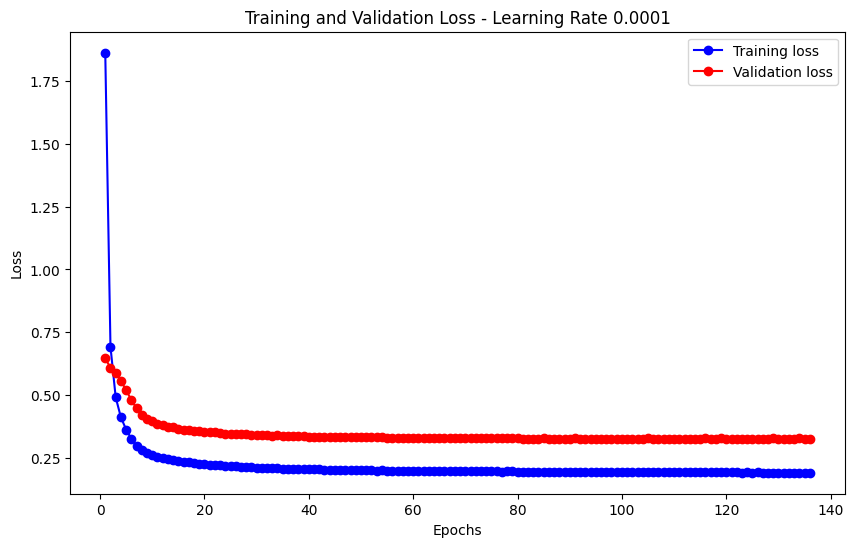

0.3228665888309479


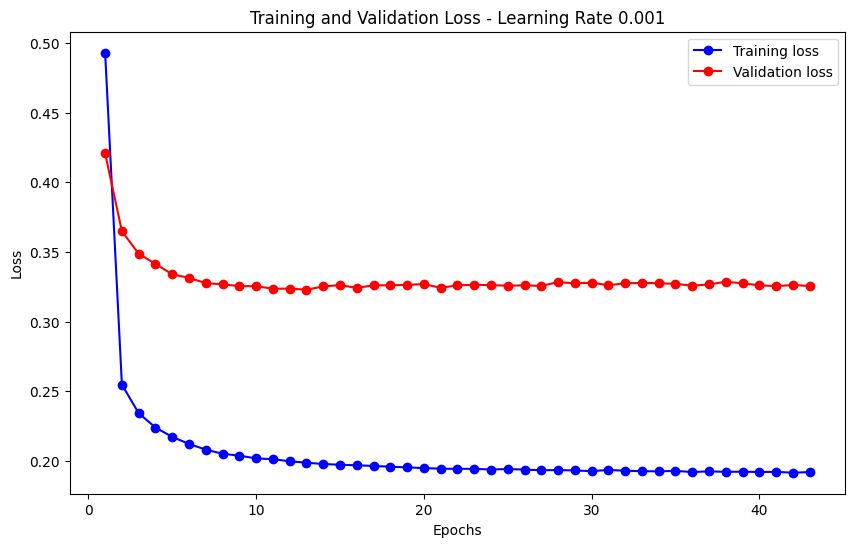

0.3065742552280426


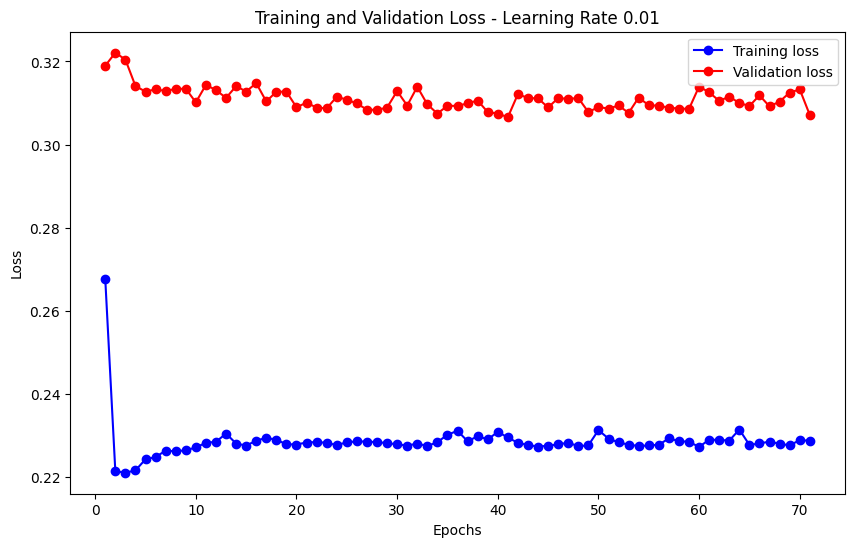

0.3031349778175354


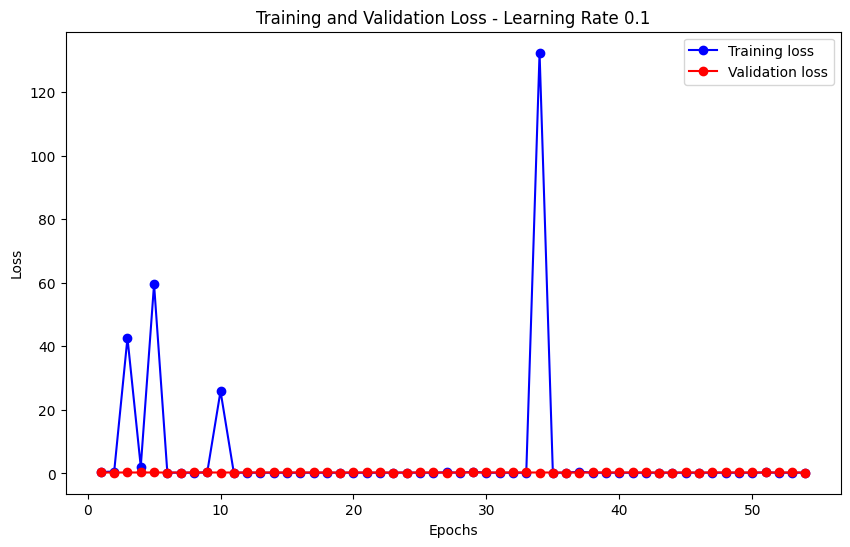

In [9]:
import matplotlib.pyplot as plt


for lr in histories:
  history = histories[lr]
  # Extracting the loss and validation loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)
  print(min(val_loss))
  # Plotting training and validation loss
  plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
  plt.plot(epochs, loss, 'bo-', label='Training loss')  # 'bo-' creates blue line with dot markers
  plt.plot(epochs, val_loss, 'ro-', label='Validation loss')  # 'ro-' creates red line with dot markers
  plt.title(f'Training and Validation Loss - Learning Rate {lr}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


In [ ]:
train_predictions_df = pd.DataFrame(model.predict(train_X), index = train_X.index, columns = train_y_full.columns)
valid_predictions_df = pd.DataFrame(model.predict(valid_X), index = valid_X.index, columns = train_y_full.columns)

215/215 [==============================] - 0s 1ms/step


In [ ]:
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene: 100%|██████████| 250/250 [00:02<00:00, 84.51it/s]


,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.754838,0.556186,215.042511,9.021381,0.532034
ENSG00000149273,0.452256,0.371183,35.022170,4.270275,0.187398
ENSG00000204628,0.557949,0.481994,50.312100,4.823148,0.294434
ENSG00000117984,0.582412,0.592000,46.785330,4.879269,0.310341
ENSG00000108518,0.620665,0.590639,61.944837,5.651034,0.360870
...,...,...,...,...,...
ENSG00000146576,0.108523,0.101317,0.377083,0.343772,0.011390
ENSG00000187713,0.119782,0.113702,0.250966,0.341118,-0.013232
ENSG00000104140,0.187213,0.168394,0.123824,0.169599,0.033668


PCC      0.309010
SRCC     0.267819
MSE     11.114854
MAE      0.987960
R2       0.108752
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.076548,0.025521,167.209989,10.148888,-0.191594
ENSG00000149273,0.423386,0.395105,322.428518,11.258803,-0.264902
ENSG00000204628,0.195089,0.137217,63.499736,5.388449,-0.051027
ENSG00000117984,0.240693,0.120605,149.371742,8.120257,-0.051816
ENSG00000108518,0.371915,0.418028,104.730424,6.348157,0.102399
...,...,...,...,...,...
ENSG00000146576,0.072246,0.073223,0.549603,0.411391,-0.017103
ENSG00000187713,0.122805,0.108316,0.319214,0.353564,0.008136
ENSG00000104140,-0.067981,-0.108581,1.716847,0.676212,-0.204813


PCC      0.139053
SRCC     0.130515
MSE     16.701321
MAE      1.310601
R2      -0.247811
dtype: float64

In [23]:
run_name = 'simple_nn'
sub_run_name = 'simple_nn'
predictions_dir = 'bucket/models/simple_nn/simple_nn/predictions'

os.makedirs(predictions_dir)


train_predicted_df = pd.DataFrame(models[0.001].predict(train_X), index = train_y_full.index, columns = train_y_full.columns)
valid_predicted_df = pd.DataFrame(models[0.001].predict(valid_X), index = valid_y_full.index, columns = valid_y_full.columns)
test_predicted_df = pd.DataFrame(models[0.001].predict(test_X), index = test_y_full.index, columns = test_y_full.columns)

train_predicted_df.to_csv(f'{predictions_dir}/train_predictions.csv')
valid_predicted_df.to_csv(f'{predictions_dir}/valid_predictions.csv')
test_predicted_df.to_csv(f'{predictions_dir}/test_predictions.csv')

train_y_full.to_csv(f'{predictions_dir}/train_y.csv')
valid_y_full.to_csv(f'{predictions_dir}/valid_y.csv')
test_y_full.to_csv(f'{predictions_dir}/test_y.csv')


191/191 [==============================] - 0s 1ms/step


In [ ]:
with open('bucket/models/simple_nn/simple_nn/predictions')
models[0.001]

In [19]:
train_predicted_df

array([[1.9624829 , 1.7335118 , 1.7590221 , ..., 0.04100448, 0.08870445,
        0.09133378],
       [2.0418484 , 1.2650974 , 1.419569  , ..., 0.02927256, 0.09174643,
        0.06708032],
       [2.054108  , 1.3367736 , 1.4783443 , ..., 0.02495226, 0.08852801,
        0.06686096],
       ...,
       [1.4873235 , 1.8491244 , 1.7413113 , ..., 0.01131873, 0.0649093 ,
        0.10779981],
       [1.3330395 , 1.787969  , 1.7170243 , ..., 0.02744287, 0.08958592,
        0.10930976],
       [1.5225067 , 1.8299807 , 1.9061013 , ..., 0.02785942, 0.1303817 ,
        0.0864602 ]], dtype=float32)

### Pytorch

In [2]:
input_size = train_X.shape[0]
output_size = train_y_full.shape[1]

import torch
import torch.nn as nn
import torch.nn.functional as F
# TODO: Hyperparameter optimization
class RegressionNet(nn.Module):
    def __init__(self, num_features, num_outputs):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # regularization 50% dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x) # regularization 50% dropout
        x = self.fc3(x)  # No activation for the output layer in regression
        return x


from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train, X_val, y_train, y_val are your data and labels in numpy arrays
X_train_tensor = torch.tensor(train_X.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(train_y_full.to_numpy(), dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(valid_X.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(valid_y_full.to_numpy(), dtype=torch.float32)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



NameError: name 'train_X' is not defined

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionNet(num_features, num_outputs).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
val_loss_history = []
train_loss_history = []
for epoch in range(num_epochs):
    model.train()
    output_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        output_loss += loss
    train_loss_history.append(output_loss / len(train_loader))

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch 1, Loss: 54.83295440673828, Val Loss: 24.549133855243063
Epoch 2, Loss: 14.097360610961914, Val Loss: 22.832997366439464
Epoch 3, Loss: 10.339029312133789, Val Loss: 20.150319185922314
Epoch 4, Loss: 10.306856155395508, Val Loss: 20.567474817675212
Epoch 5, Loss: 5.897250652313232, Val Loss: 19.211786993159805
Epoch 6, Loss: 6.763164520263672, Val Loss: 18.198352957880775
Epoch 7, Loss: 3.970409631729126, Val Loss: 18.847905083589776
Epoch 8, Loss: 7.847042560577393, Val Loss: 19.063116284303888
Epoch 9, Loss: 7.150516986846924, Val Loss: 18.31782967101696
Epoch 10, Loss: 28.818151473999023, Val Loss: 19.91104703282201
Epoch 11, Loss: 12.403979301452637, Val Loss: 19.176875529178353
Epoch 12, Loss: 24.982589721679688, Val Loss: 19.003719602629197
Epoch 13, Loss: 4.674886703491211, Val Loss: 19.134146812350252
Epoch 14, Loss: 38.46846389770508, Val Loss: 19.85740318076555
Epoch 15, Loss: 18.551319122314453, Val Loss: 19.44595683785372
Epoch 16, Loss: 14.528260231018066, Val Loss: 

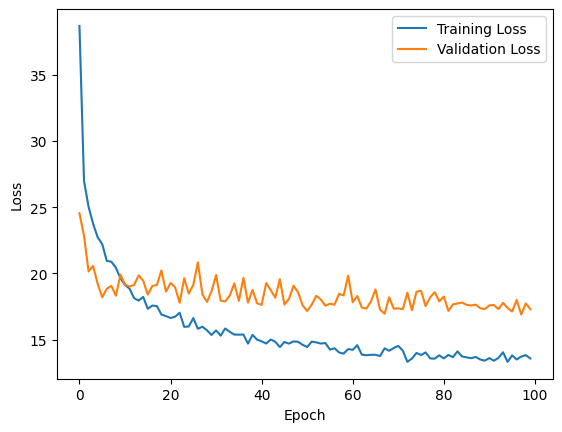

In [ ]:
import matplotlib.pyplot as plt

# Assume loss_history and val_loss_history are lists that you've filled during the training loop
train_loss_history = list(map(lambda x: x.item(), train_loss_history))
val_loss_history = list(map(lambda x: x, val_loss_history))

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Simple GAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class GraphConvolution(nn.Module):
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, dropout=0., act=F.relu,bias=True):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.act = act
        self.weight=nn.parameter.Parameter(torch.FloatTensor(input_dim, output_dim))
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        """Create a weight variable with Glorot & Bengio (AISTATS 2010)
        initialization.
        """
        init_range = np.sqrt(6.0 / (self.input_dim + self.output_dim))
        nn.init.uniform_(self.weight, a=-init_range, b=init_range)

        if self.bias is not None:
            nn.init.uniform_(self.bias,a=-init_range, b=init_range)

    def forward(self,input,adj):
        input = F.dropout(input, self.dropout, self.training)
        support = torch.mm(input, self.weight)
        output = torch.sparse.mm(adj, support)
        if self.bias is not None:
            output= output + self.bias
        output = self.act(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.input_dim) + ' -> '+ str(self.output_dim) + ')'

class InnerProductDecoder(nn.Module):
    """Decoder model layer for link prediction."""
    def __init__(self, dropout, act=lambda x: x):
        super(InnerProductDecoder, self).__init__()
        self.dropout = dropout
        self.act = act

    def forward(self, inputs):
        inputs=F.dropout(inputs, self.dropout, training=self.training)
        x=torch.mm(inputs, inputs.t())
        outputs = self.act(x)
        return outputs

class FC(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0., act=F.leaky_relu, batchnorm=False,bias=False):
#     def __init__(self, input_dim, output_dim, dropout=0., act=F.leaky_relu, batchnorm=True,bias=True):
        super(FC, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.act = act
        self.batchnorm=batchnorm
        self.linearlayer=nn.Linear(input_dim,output_dim,bias=bias)
        if batchnorm:
            self.batchnormlayer=nn.BatchNorm1d(output_dim)

    def forward(self,input):
        input = F.dropout(input, self.dropout, self.training)
        output = self.linearlayer(input)
        if self.batchnorm:
            output=self.batchnormlayer(output)
        output = self.act(output)
        return output


class GCNModelVAE_XA_e2_d1_DCA(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim1,hidden_dim2,hidden_decoder, dropout,meanMin=1e-5,meanMax=1e6,thetaMin=1e-5,thetaMax=1e6):
        super(GCNModelVAE_XA_e2_d1_DCA, self).__init__()
        self.gc1 = GraphConvolution(input_feat_dim, hidden_dim1, dropout, act=F.leaky_relu)
        self.gc2 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=F.leaky_relu)
        self.gc2s = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=F.leaky_relu)
        self.dc = InnerProductDecoder(dropout, act=lambda x: x)
        self.fc1 = FC(hidden_dim2, hidden_decoder, dropout, act = F.leaky_relu, batchnorm = True)
        self.pi= FC(hidden_decoder, input_feat_dim, dropout=0, act = torch.sigmoid, batchnorm = False,bias=True)
        self.theta= FC(hidden_decoder, input_feat_dim, dropout=0, act = lambda x: torch.clamp(F.softplus(x),min=thetaMin,max=thetaMax), batchnorm = False,bias=True)
        self.mean= FC(hidden_decoder, input_feat_dim, dropout=0, act = lambda x: torch.clamp(torch.exp(x),min=meanMin,max=meanMax), batchnorm = False,bias=True)

    def encode(self, x, adj):
        hidden1=self.gc1(x,adj)
        return self.gc2(hidden1, adj), self.gc2s(hidden1, adj)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode_X(self,z):
        output = self.fc1(z)
        pi_res=self.pi(output)
        theta_res=self.theta(output)
        mean_res=self.mean(output)
        return output,pi_res,theta_res,mean_res

    def forward(self, x, adj):
        mu, logvar = self.encode(x, adj)
        z = self.reparameterize(mu, logvar)
        return self.dc(z), mu, logvar, z, self.decode_X(z)

In [ ]:
import anndata

# get adjacency matrix
for i, record in train_metadata.iterrows():
  print(
adj_mat = pd.read_csv('adj_matrix')

In [ ]:
from gc import collect
collect()

224